# Lab 7-3 - Predicting snowmelt rates with the Temperature-Index method

In this lab, we will use SWE and air temperature measurements from the East River Valley (SNOTEL sites, plus the Kettle Ponds measurements).

In [1]:
import pandas as pd
from metloom.pointdata import SnotelPointData
import altair as alt
import numpy as np
from metpy.units import units
import numpy as np
import altair as alt
alt.data_transformers.disable_max_rows()
import matplotlib.pyplot as plt

In [2]:
start_date = '1990-01-01'
end_date = '2024-01-10'

## Download SNOTEL SWE data

In [3]:
snotel_point_butte = SnotelPointData("380:CO:SNTL", "Butte")
SNOTEL_VARS = [
    snotel_point_butte.ALLOWED_VARIABLES.SWE,
    snotel_point_butte.ALLOWED_VARIABLES.TEMPMAX,
    snotel_point_butte.ALLOWED_VARIABLES.PRECIPITATION
]
df_butte_longterm = snotel_point_butte.get_daily_data(
    pd.to_datetime(start_date), pd.to_datetime(end_date),
    SNOTEL_VARS
)
df_butte_longterm = df_butte_longterm.reset_index()
df_butte_longterm.head()

datetime         site  \
0 1990-01-01 08:00:00+00:00  380:CO:SNTL   
1 1990-01-02 08:00:00+00:00  380:CO:SNTL   
2 1990-01-03 08:00:00+00:00  380:CO:SNTL   
3 1990-01-04 08:00:00+00:00  380:CO:SNTL   
4 1990-01-05 08:00:00+00:00  380:CO:SNTL   

                                    geometry  SWE SWE_units  MAX AIR TEMP  \
0  POINT Z (-106.95327 38.89435 10190.00000)  2.3        in         26.42   
1  POINT Z (-106.95327 38.89435 10190.00000)  2.3        in         23.54   
2  POINT Z (-106.95327 38.89435 10190.00000)  2.3        in         18.50   
3  POINT Z (-106.95327 38.89435 10190.00000)  2.3        in         12.02   
4  POINT Z (-106.95327 38.89435 10190.00000)  2.4        in         19.58   

  MAX AIR TEMP_units  PRECIPITATION PRECIPITATION_units datasource  
0               degF            0.0                  in       NRCS  
1               degF            0.0                  in       NRCS  
2               degF            0.0                  in       NRCS  
3               degF            0.1                  in       NRCS  
4               degF            0.0                  in       NRCS

Add columns for year, and then a date object without a year specified (or, actually, where all the years have been replaced with the year 2000). The year column is useful for grouping the datasets into separate years. The "date_no_year" column is useful for plotting SWE evolution from each year on the same chart.

In [4]:
df_butte_longterm['year'] = df_butte_longterm['datetime'].dt.year
df_butte_longterm['date_no_year'] = df_butte_longterm['datetime'].apply(
    lambda dt: dt.replace(year=1999) if dt.month in [10,11,12] else dt.replace(year=2000)
)

Plot annual SWE pattern for all years

In [5]:
alt.Chart(df_butte_longterm).mark_line().encode(
    alt.X('date_no_year'),
    alt.Y('SWE:Q'),
    alt.Color('year:Q')
).properties(width=600)

alt.Chart(...)

# Calculate melt rate from daily ∆ SWE

We calculate 
$$Melt Rate = - ∆SWE$$
where ∆SWE is calculated as SWE on the second day minus SWE on the first day.

To do the calculation with our dataframe, we first group by year, then calculate the difference in SWE on consecutive days, using the `diff` function.

In [6]:
delta_swe = df_butte_longterm.groupby('year').apply(lambda df: df.set_index('datetime')[['SWE']].diff())
delta_swe = delta_swe.rename(columns={'SWE': 'Delta SWE'})

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_59981/3218391937.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  delta_swe = df_butte_longterm.groupby('year').apply(lambda df: df.set_index('datetime')[['SWE']].diff())


The plot above shows us that the ablation period usually doesn't usually start until April 1st, so we will focus on data from after April 1st when we calculate melt rates. Also, we see the snow is always gone before the end of June. So we remove data from before April and after June.

In [7]:
delta_swe = delta_swe[delta_swe.index.get_level_values(1).month > 3] 
delta_swe = delta_swe[delta_swe.index.get_level_values(1).month < 7]
delta_swe.head()

Delta SWE
year datetime                            
1990 1990-04-01 08:00:00+00:00        0.0
     1990-04-02 08:00:00+00:00        0.0
     1990-04-03 08:00:00+00:00        0.0
     1990-04-04 08:00:00+00:00        0.0
     1990-04-05 08:00:00+00:00        0.0

Let's also remove days where SWE increased. We don't want to estimate a melt rate relationship on days where we did not observe melting. Also, let's calculate Melt Rate by simply negative the ∆SWE.

In [8]:
delta_swe = delta_swe[delta_swe['Delta SWE'] < 0]

delta_swe['MELT RATE'] = - delta_swe['Delta SWE']

Ok we now have a dataset of melt rates during snowpack ablation, in units of inches/day, for 20 years of data, in a nice table.

In [9]:
delta_swe.head()

Delta SWE  MELT RATE
year datetime                                       
1990 1990-04-12 08:00:00+00:00       -0.3        0.3
     1990-04-13 08:00:00+00:00       -0.1        0.1
     1990-04-15 08:00:00+00:00       -0.3        0.3
     1990-04-16 08:00:00+00:00       -0.4        0.4
     1990-04-17 08:00:00+00:00       -0.4        0.4

Let's add columns of maximum daily air temperature and precipitation, from the Snotel dataset that we initially downloaded. We can join our two tables on the datetime index.

In [10]:
delta_swe = delta_swe.reset_index().set_index('datetime').join(
    df_butte_longterm.set_index('datetime')[['MAX AIR TEMP', 'PRECIPITATION']]
)
delta_swe.head()

year  Delta SWE  MELT RATE  MAX AIR TEMP  \
datetime                                                              
1990-04-12 08:00:00+00:00  1990       -0.3        0.3         47.30   
1990-04-13 08:00:00+00:00  1990       -0.1        0.1         40.46   
1990-04-15 08:00:00+00:00  1990       -0.3        0.3         51.98   
1990-04-16 08:00:00+00:00  1990       -0.4        0.4         54.50   
1990-04-17 08:00:00+00:00  1990       -0.4        0.4         45.14   

                           PRECIPITATION  
datetime                                  
1990-04-12 08:00:00+00:00            0.1  
1990-04-13 08:00:00+00:00            0.0  
1990-04-15 08:00:00+00:00            0.0  
1990-04-16 08:00:00+00:00            0.1  
1990-04-17 08:00:00+00:00            0.1

Let's convert our units to metric. Currently, the SWE column is mm/day and the MAX AIR TEMP column is ˚F.

In [11]:
delta_swe['Delta SWE'] = (delta_swe['Delta SWE'].values * units('inches')).to(units('millimeters')).magnitude
delta_swe['MAX AIR TEMP'] = (delta_swe['MAX AIR TEMP'].values * units('degF')).to(units('degC')).magnitude
delta_swe['PRECIPITATION'] = (delta_swe['PRECIPITATION'].values * units('inches')).to(units('millimeters')).magnitude
delta_swe['MELT RATE'] = (delta_swe['MELT RATE'].values * units('inches')).to(units('millimeters')).magnitude

Now let's plot the relationship between ∆SWE and max daily air temp. There are lots of data points here, so let's plot a scatterplot as well as a "2d histogram" representing point density.

In [12]:
chart_scatter = alt.Chart(delta_swe).mark_point(size=5).encode(
    alt.X('MAX AIR TEMP:Q').title('Max daily air temp. (˚C)'),
    alt.Y('MELT RATE:Q').title('Melt rate (mm/day)')
)
chart_2d_histogram = alt.Chart(delta_swe).mark_rect().encode(
    alt.X('MAX AIR TEMP:Q', bin=alt.Bin(maxbins=30)).title('Max daily air temp. (˚C)'),
    alt.Y('MELT RATE:Q', bin=alt.Bin(maxbins=30)).title('Melt rate (mm/day)'),
    alt.Color('count()').title('Point Density')
)
(chart_scatter | chart_2d_histogram).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

# Fit a Temperature-Index equation

Now, we can fit a line to our data,

$$ M = M_f (T_a - T_0), $$

and find the find the degree day factor $M_f$. Note that because we are assuming $T_0 = 0$, we can just ignore it and fit a line assuming a zero intercet,

$$ M = M_f (T_a). $$

Considering the data above, we will remove outliers where the max daily air temp is greater than 25˚C, because these do not seem to follow the major pattern.

In [13]:
# filter data points
src = delta_swe[delta_swe['MAX AIR TEMP'] < 25]

# Perform linear regression with zero intercept
x = src['MAX AIR TEMP']
y = src['MELT RATE']
DEGREE_DAY_FACTOR = np.sum(x * y) / np.sum(x * x)

Plot the line on top of the charts above!

In [14]:
# Create the plot for the line of best fit
# Line of best fit using the slope (DEGREE_DAY_FACTOR) and zero intercept
line = alt.Chart(src).mark_line(color='red').encode(
    alt.X('MAX AIR TEMP:Q'),
    alt.Y('MELT RATE:Q')
).transform_calculate(
    "MELT RATE", f"{DEGREE_DAY_FACTOR} * datum['MAX AIR TEMP']"
)

# Add it to the charts above.
# Add the estimated degree day factor (the DEGREE_DAY_FACTOR of the line of best fit)
#    to the charts.
(
    (chart_scatter + line).properties(title=f'M_f = {round(DEGREE_DAY_FACTOR,2)} mm/˚C/day')  
    | 
    (chart_2d_histogram + line).properties(title=f'M_f = {round(DEGREE_DAY_FACTOR,2)} mm/˚C/day')
).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

# Predict snowpack ablation for one year

Using this Temperature-Index model, we can predict snowmelt for a given year, even if we only have an air temperature measurement.
Let's try to predict snow melt at the Butte Snotel site using the fitted Temperature-Index model we created above. 
We will do this for the 2022-2023 winter season (the same year as the SOS campaign).

Using the Temperature-Index model/equation, we can simply estimate snowmelt for a given day. For this modeling exercise, we will "initialize the model" with the *measured* April 1 SWE. We will then apply the model (i.e. estimate daily snow melt) using the measured air temps. 

First, let's grab the data we want for the single snow season.

In [15]:
# Grab Snotel-measured data from the 2022-23 water year
df_butte_2023 = df_butte_longterm.set_index('datetime').loc['20230401': '20230630']

## convert SWE from inches to mm and air temp from F to C
df_butte_2023['SWE'] = (df_butte_2023['SWE'].values * units("inches")).to(units("mm"))
df_butte_2023['MAX AIR TEMP'] = (df_butte_2023['MAX AIR TEMP'].values * units("degF")).to(units("degC"))
df_butte_2023['PRECIPITATION'] = (df_butte_2023['PRECIPITATION'].values * units("inches")).to(units("mm"))

Now, we can calculate "predicted melt rate" simply from air temperature, and the DEGREE_DAY_FACTOR we calculated above, from 20 years of historical data.

In [16]:
# calculate melt rate from max air temp. Use the DEGREE_DAY_FACTOR calculated above
df_butte_2023['melt rate'] = df_butte_2023['MAX AIR TEMP'] * DEGREE_DAY_FACTOR

Now, we will use daily melt rates to model snowpack ablation. Recall, we need to "initialize" the modeled snowpack - we do this with measured SWE on April 1. Then, we will loop over each day, applying the estimated melt rate to the modeled snowpack.

In [17]:
# get the initial SWE value from measurements
swe_measured_initial_value = df_butte_2023['SWE'].iloc[0]

# calculate modeled SWE, modeling ablation using the estimated melt rates
#   First, create a list that will hold the modeled, daily SWE
modeled_swe = [swe_measured_initial_value]

#   Second, loop over melt rates from each day, calculate the new
#   SWE using the melt rate from the previous day.
for melt_rate in df_butte_2023['melt rate']:
    updated_swe = modeled_swe[-1] - melt_rate
    if updated_swe >= 0:
        modeled_swe.append(updated_swe)
    else:
        modeled_swe.append(0)

# Add the modeled SWE back into our dataframe. We remove the last predicted SWE value because we have one day of modeled SWE beyond our measured SWE.
df_butte_2023['SWE predicted'] = modeled_swe[:-1]

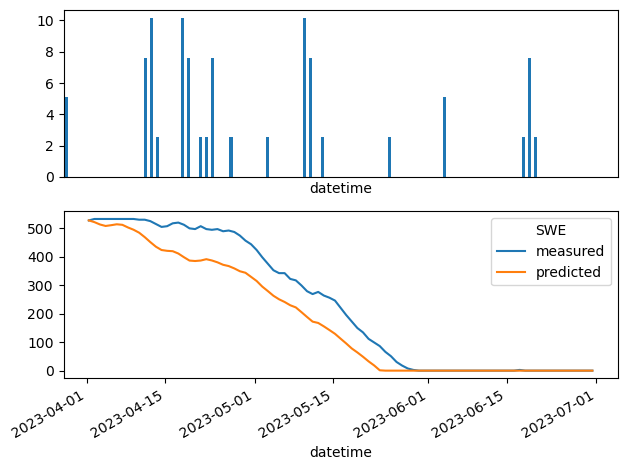

In [18]:
fig, axes = plt.subplots(2,1)
df_butte_2023['SWE'].plot(label='measured', ax = axes[1])
df_butte_2023['SWE predicted'].plot(label='predicted', ax = axes[1])
df_butte_2023['PRECIPITATION'].plot.bar(ax=axes[0])
axes[0].set_xticks([])
plt.legend(title='SWE')
plt.tight_layout()

So it looks like our predicted SWE results in a melt out about 5 days earlier than actual SWE. Not too bad, huh? Also, it looks like a lot of the divergence between measured and predicted ablation coincides with precipitation.